In [400]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [401]:
companies = ['DKNG','FB','MSFT','GOOG']
data = pd.read_csv(f"../Data/stocks/{companies[1]}.csv")

In [402]:
close = data['Close'].values

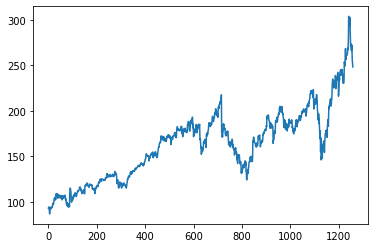

In [403]:
plt.plot(close)
plt.show()

In [404]:
T = 15
O = 15
X = []
Y = []
for t in range(len(close)-T-O):
    x = close[t:t+T]
    X.append(x)
    y = close[t+T:t+T+O]
    Y.append(y)

In [405]:
X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(-1,O)

In [406]:
print("X.shape",X.shape, "Y.shape",Y.shape)

X.shape (1229, 15, 1) Y.shape (1229, 15)


In [407]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [408]:
### Define LSTM
class LSTM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_rnnlayers, n_outputs, n_fc_hidden):
        super().__init__()
        self.D = n_inputs
        self.M = n_hiddens
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.lstm = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        self.fc = nn.Linear(self.M, n_fc_hidden)
        self.fc2 = nn.Linear(n_fc_hidden,n_fc_hidden)
        self.fc3 = nn.Linear(n_fc_hidden,n_fc_hidden)
        self.fc4 = nn.Linear(n_fc_hidden, n_outputs)
        self.drop = nn.Dropout(.5)
        
    def forward(self, X):
        # Initial Hidden states and Cell states
        h0 = torch.zeros(self.L, X.shape[0], self.M).to(device)
        c0 = torch.zeros(self.L, X.shape[0], self.M).to(device)
        
        # get LSTM output
        # out is of size (N, T, M)
        out, _ = self.lstm(X,(h0,c0))
        
        # we only use h(t) at the final timestep
        out = self.drop(F.relu(self.fc(out[:,-1,:])))
        out = self.drop(F.relu(self.fc2(out)))
        out = self.drop(F.relu(self.fc3(out)))
        out = self.fc4(out)
        return out

In [409]:
model = LSTM(n_inputs=1, n_hiddens=130, n_rnnlayers=2, n_outputs=O,n_fc_hidden=60)
model.to(device)

LSTM(
  (lstm): LSTM(1, 130, num_layers=2, batch_first=True)
  (fc): Linear(in_features=130, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=15, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [410]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [411]:
# Make inputs and targets
N = X.shape[0]
train_por = 0.9
size = int(N * train_por)
X_train = torch.from_numpy(X[:-T].astype(np.float32))
y_train = torch.from_numpy(Y[:-T].astype(np.float32))
X_test = torch.from_numpy(X[-T:].astype(np.float32))
y_test = torch.from_numpy(Y[-T:].astype(np.float32))

In [412]:
print("Train X ",X_train.shape,"Train y", y_train.shape)

Train X  torch.Size([1214, 15, 1]) Train y torch.Size([1214, 15])


In [413]:
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

In [414]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Storing losses.
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward Optimization
        loss.backward()
        optimizer.step()
        
        # Save loss
        train_losses[epoch] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]. Train loss : {loss.item():.3f}. Test loss : {test_loss.item():.3f}')
            
        if (epoch + 1) % 1000 == 0:
            with torch.no_grad():
                pred = model(X_test[-1].reshape(1,T,1))
                plt.plot(X_test[-1].cpu())
                plt.plot(np.arange(pred.shape[1])+14,pred.reshape(-1).cpu(),label="Predicted")
                plt.plot(np.arange(pred.shape[1])+14,y_test[-1].reshape(-1).cpu(), label="Actual")
                plt.legend()
                plt.show()

    return train_losses, test_losses

Epoch [100/20000]. Train loss : 3923.073. Test loss : 15549.136
Epoch [200/20000]. Train loss : 3373.401. Test loss : 16675.436
Epoch [300/20000]. Train loss : 3422.400. Test loss : 16290.850
Epoch [400/20000]. Train loss : 1970.072. Test loss : 5866.180
Epoch [500/20000]. Train loss : 1880.612. Test loss : 5177.358
Epoch [600/20000]. Train loss : 1742.515. Test loss : 5032.066
Epoch [700/20000]. Train loss : 1808.845. Test loss : 6291.666
Epoch [800/20000]. Train loss : 1680.379. Test loss : 7801.849
Epoch [900/20000]. Train loss : 1601.348. Test loss : 5549.155
Epoch [1000/20000]. Train loss : 1577.383. Test loss : 5190.427


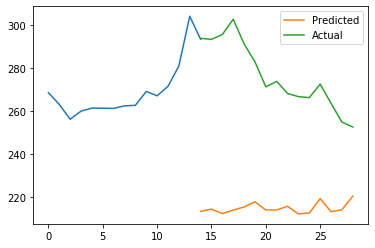

Epoch [1100/20000]. Train loss : 1335.432. Test loss : 4248.571
Epoch [1200/20000]. Train loss : 1356.930. Test loss : 3637.205
Epoch [1300/20000]. Train loss : 1181.407. Test loss : 1675.081
Epoch [1400/20000]. Train loss : 1109.880. Test loss : 2170.742
Epoch [1500/20000]. Train loss : 1125.195. Test loss : 4827.514
Epoch [1600/20000]. Train loss : 973.286. Test loss : 3491.138
Epoch [1700/20000]. Train loss : 1005.815. Test loss : 5506.031
Epoch [1800/20000]. Train loss : 980.012. Test loss : 3199.747
Epoch [1900/20000]. Train loss : 962.087. Test loss : 3598.044
Epoch [2000/20000]. Train loss : 958.807. Test loss : 2748.673


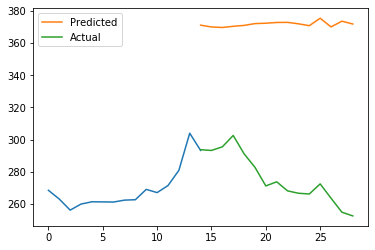

Epoch [2100/20000]. Train loss : 1000.258. Test loss : 1490.055
Epoch [2200/20000]. Train loss : 949.385. Test loss : 5071.588
Epoch [2300/20000]. Train loss : 965.857. Test loss : 5812.928
Epoch [2400/20000]. Train loss : 895.952. Test loss : 2739.263
Epoch [2500/20000]. Train loss : 891.999. Test loss : 1869.914
Epoch [2600/20000]. Train loss : 797.620. Test loss : 2924.155
Epoch [2700/20000]. Train loss : 890.794. Test loss : 3777.310
Epoch [2800/20000]. Train loss : 852.227. Test loss : 4055.855
Epoch [2900/20000]. Train loss : 871.635. Test loss : 2288.023
Epoch [3000/20000]. Train loss : 853.641. Test loss : 2352.352


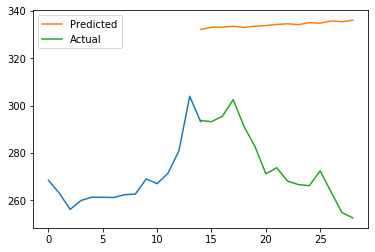

Epoch [3100/20000]. Train loss : 881.127. Test loss : 2634.828
Epoch [3200/20000]. Train loss : 854.786. Test loss : 4044.623
Epoch [3300/20000]. Train loss : 796.451. Test loss : 3470.757
Epoch [3400/20000]. Train loss : 895.889. Test loss : 3984.980
Epoch [3500/20000]. Train loss : 797.432. Test loss : 2870.403
Epoch [3600/20000]. Train loss : 854.168. Test loss : 1836.993
Epoch [3700/20000]. Train loss : 796.371. Test loss : 3125.090
Epoch [3800/20000]. Train loss : 757.948. Test loss : 5352.495
Epoch [3900/20000]. Train loss : 822.624. Test loss : 4172.991
Epoch [4000/20000]. Train loss : 706.997. Test loss : 2700.031


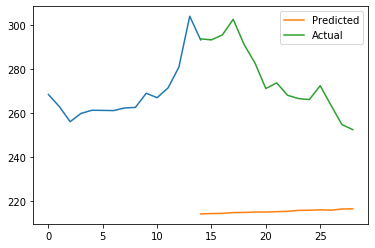

Epoch [4100/20000]. Train loss : 767.244. Test loss : 3377.481
Epoch [4200/20000]. Train loss : 701.451. Test loss : 2259.723
Epoch [4300/20000]. Train loss : 681.334. Test loss : 4147.481
Epoch [4400/20000]. Train loss : 697.366. Test loss : 2555.881
Epoch [4500/20000]. Train loss : 701.578. Test loss : 2577.282
Epoch [4600/20000]. Train loss : 676.351. Test loss : 1540.085
Epoch [4700/20000]. Train loss : 688.346. Test loss : 2654.635
Epoch [4800/20000]. Train loss : 608.508. Test loss : 2243.963
Epoch [4900/20000]. Train loss : 611.814. Test loss : 1680.109
Epoch [5000/20000]. Train loss : 645.434. Test loss : 3306.063


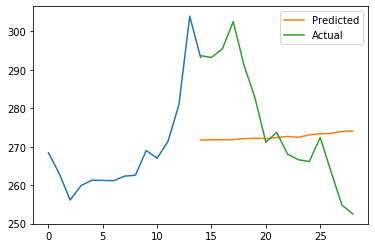

Epoch [5100/20000]. Train loss : 614.263. Test loss : 2743.563
Epoch [5200/20000]. Train loss : 574.586. Test loss : 2002.894
Epoch [5300/20000]. Train loss : 573.777. Test loss : 1534.401
Epoch [5400/20000]. Train loss : 619.247. Test loss : 2051.368
Epoch [5500/20000]. Train loss : 580.975. Test loss : 3697.945
Epoch [5600/20000]. Train loss : 623.259. Test loss : 2236.234
Epoch [5700/20000]. Train loss : 596.837. Test loss : 2495.421
Epoch [5800/20000]. Train loss : 568.423. Test loss : 4126.083
Epoch [5900/20000]. Train loss : 607.095. Test loss : 1058.999
Epoch [6000/20000]. Train loss : 593.668. Test loss : 2204.524


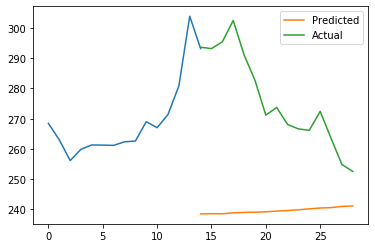

Epoch [6100/20000]. Train loss : 600.969. Test loss : 2304.173
Epoch [6200/20000]. Train loss : 583.452. Test loss : 4007.453
Epoch [6300/20000]. Train loss : 600.559. Test loss : 3651.505
Epoch [6400/20000]. Train loss : 577.676. Test loss : 3405.411
Epoch [6500/20000]. Train loss : 575.933. Test loss : 2882.829
Epoch [6600/20000]. Train loss : 595.713. Test loss : 1838.693
Epoch [6700/20000]. Train loss : 612.688. Test loss : 1763.386
Epoch [6800/20000]. Train loss : 582.113. Test loss : 1718.257
Epoch [6900/20000]. Train loss : 506.498. Test loss : 1813.003
Epoch [7000/20000]. Train loss : 563.277. Test loss : 3101.149


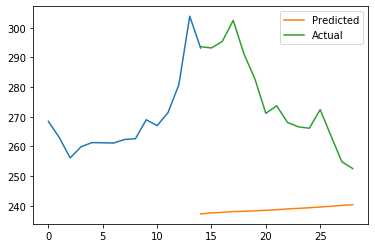

Epoch [7100/20000]. Train loss : 612.240. Test loss : 2311.938
Epoch [7200/20000]. Train loss : 604.794. Test loss : 2010.751
Epoch [7300/20000]. Train loss : 557.314. Test loss : 4070.713
Epoch [7400/20000]. Train loss : 540.320. Test loss : 4822.610
Epoch [7500/20000]. Train loss : 554.224. Test loss : 1051.499
Epoch [7600/20000]. Train loss : 579.503. Test loss : 3105.474
Epoch [7700/20000]. Train loss : 612.091. Test loss : 1951.296
Epoch [7800/20000]. Train loss : 581.705. Test loss : 3079.810
Epoch [7900/20000]. Train loss : 603.114. Test loss : 2757.438
Epoch [8000/20000]. Train loss : 574.544. Test loss : 3406.475


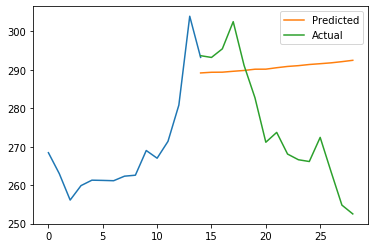

Epoch [8100/20000]. Train loss : 529.239. Test loss : 2650.445
Epoch [8200/20000]. Train loss : 591.313. Test loss : 1812.021
Epoch [8300/20000]. Train loss : 565.521. Test loss : 2527.320
Epoch [8400/20000]. Train loss : 553.013. Test loss : 1596.361
Epoch [8500/20000]. Train loss : 566.856. Test loss : 1793.787
Epoch [8600/20000]. Train loss : 551.354. Test loss : 1673.320
Epoch [8700/20000]. Train loss : 532.498. Test loss : 2524.766
Epoch [8800/20000]. Train loss : 555.755. Test loss : 1751.097
Epoch [8900/20000]. Train loss : 562.881. Test loss : 1673.806
Epoch [9000/20000]. Train loss : 536.247. Test loss : 2216.506


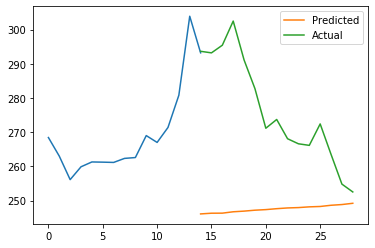

Epoch [9100/20000]. Train loss : 517.837. Test loss : 3130.521
Epoch [9200/20000]. Train loss : 546.457. Test loss : 2921.725
Epoch [9300/20000]. Train loss : 581.742. Test loss : 2120.136
Epoch [9400/20000]. Train loss : 535.815. Test loss : 2154.171
Epoch [9500/20000]. Train loss : 527.753. Test loss : 1285.398
Epoch [9600/20000]. Train loss : 585.657. Test loss : 2286.225
Epoch [9700/20000]. Train loss : 519.916. Test loss : 2214.002
Epoch [9800/20000]. Train loss : 555.093. Test loss : 1908.033
Epoch [9900/20000]. Train loss : 569.018. Test loss : 2005.769
Epoch [10000/20000]. Train loss : 521.085. Test loss : 2111.852


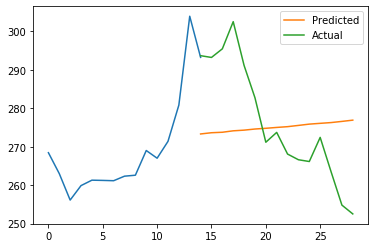

Epoch [10100/20000]. Train loss : 501.975. Test loss : 1383.278
Epoch [10200/20000]. Train loss : 543.523. Test loss : 3807.484
Epoch [10300/20000]. Train loss : 530.724. Test loss : 2808.878
Epoch [10400/20000]. Train loss : 541.155. Test loss : 2648.956
Epoch [10500/20000]. Train loss : 546.608. Test loss : 2547.984
Epoch [10600/20000]. Train loss : 539.696. Test loss : 2448.442
Epoch [10700/20000]. Train loss : 580.428. Test loss : 3238.109
Epoch [10800/20000]. Train loss : 525.964. Test loss : 2554.608
Epoch [10900/20000]. Train loss : 574.522. Test loss : 1683.884
Epoch [11000/20000]. Train loss : 530.629. Test loss : 1501.290


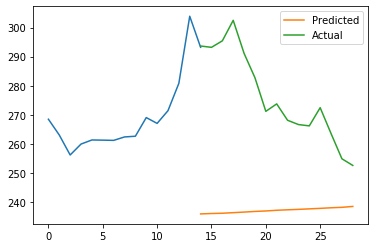

Epoch [11100/20000]. Train loss : 515.326. Test loss : 1748.383
Epoch [11200/20000]. Train loss : 545.816. Test loss : 2180.059
Epoch [11300/20000]. Train loss : 537.633. Test loss : 2974.364
Epoch [11400/20000]. Train loss : 482.802. Test loss : 1960.878
Epoch [11500/20000]. Train loss : 529.262. Test loss : 2706.746
Epoch [11600/20000]. Train loss : 549.404. Test loss : 3263.610
Epoch [11700/20000]. Train loss : 560.687. Test loss : 4668.370
Epoch [11800/20000]. Train loss : 534.316. Test loss : 1666.216
Epoch [11900/20000]. Train loss : 530.342. Test loss : 3775.944
Epoch [12000/20000]. Train loss : 529.056. Test loss : 1704.471


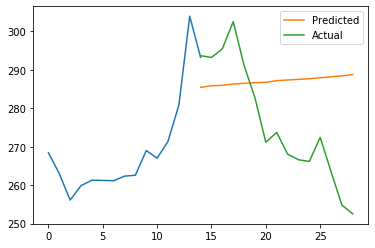

Epoch [12100/20000]. Train loss : 538.566. Test loss : 3093.223
Epoch [12200/20000]. Train loss : 520.279. Test loss : 3084.495
Epoch [12300/20000]. Train loss : 526.459. Test loss : 1922.405
Epoch [12400/20000]. Train loss : 560.466. Test loss : 1599.410
Epoch [12500/20000]. Train loss : 544.568. Test loss : 1969.189
Epoch [12600/20000]. Train loss : 520.920. Test loss : 2435.793
Epoch [12700/20000]. Train loss : 545.382. Test loss : 1626.790
Epoch [12800/20000]. Train loss : 498.167. Test loss : 2285.451
Epoch [12900/20000]. Train loss : 563.552. Test loss : 3124.067
Epoch [13000/20000]. Train loss : 545.428. Test loss : 1746.142


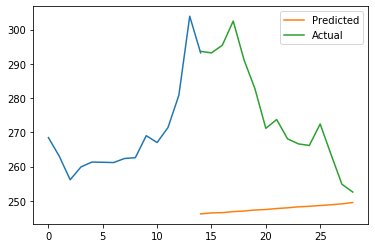

Epoch [13100/20000]. Train loss : 588.074. Test loss : 2835.798
Epoch [13200/20000]. Train loss : 526.840. Test loss : 2907.538
Epoch [13300/20000]. Train loss : 526.850. Test loss : 3835.126
Epoch [13400/20000]. Train loss : 531.667. Test loss : 1682.643
Epoch [13500/20000]. Train loss : 486.174. Test loss : 2143.344
Epoch [13600/20000]. Train loss : 520.242. Test loss : 3273.254
Epoch [13700/20000]. Train loss : 529.642. Test loss : 2896.605
Epoch [13800/20000]. Train loss : 505.125. Test loss : 2444.543
Epoch [13900/20000]. Train loss : 530.430. Test loss : 2935.772
Epoch [14000/20000]. Train loss : 534.790. Test loss : 1590.972


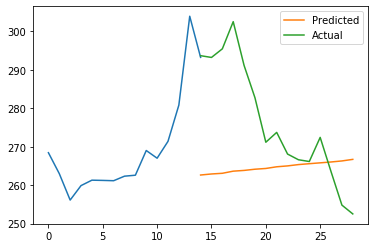

Epoch [14100/20000]. Train loss : 543.039. Test loss : 2746.333
Epoch [14200/20000]. Train loss : 536.597. Test loss : 1667.623
Epoch [14300/20000]. Train loss : 523.874. Test loss : 1497.649
Epoch [14400/20000]. Train loss : 559.960. Test loss : 3161.612
Epoch [14500/20000]. Train loss : 553.531. Test loss : 2278.015
Epoch [14600/20000]. Train loss : 560.162. Test loss : 2646.955
Epoch [14700/20000]. Train loss : 534.896. Test loss : 3148.417
Epoch [14800/20000]. Train loss : 517.856. Test loss : 2186.676
Epoch [14900/20000]. Train loss : 538.695. Test loss : 2251.387
Epoch [15000/20000]. Train loss : 506.374. Test loss : 1993.790


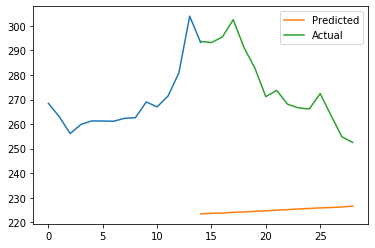

Epoch [15100/20000]. Train loss : 523.316. Test loss : 3095.118
Epoch [15200/20000]. Train loss : 484.747. Test loss : 1760.578
Epoch [15300/20000]. Train loss : 493.467. Test loss : 2309.908
Epoch [15400/20000]. Train loss : 488.101. Test loss : 2292.777
Epoch [15500/20000]. Train loss : 514.884. Test loss : 2770.050
Epoch [15600/20000]. Train loss : 570.780. Test loss : 2375.833
Epoch [15700/20000]. Train loss : 525.995. Test loss : 1254.410
Epoch [15800/20000]. Train loss : 531.850. Test loss : 1470.396
Epoch [15900/20000]. Train loss : 531.077. Test loss : 2546.559
Epoch [16000/20000]. Train loss : 468.720. Test loss : 3821.531


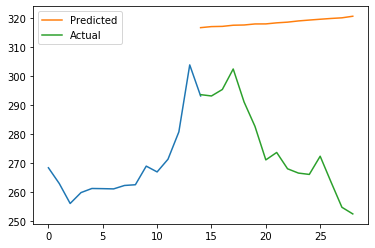

Epoch [16100/20000]. Train loss : 515.315. Test loss : 2275.108
Epoch [16200/20000]. Train loss : 503.810. Test loss : 1847.883
Epoch [16300/20000]. Train loss : 494.763. Test loss : 1735.510
Epoch [16400/20000]. Train loss : 517.144. Test loss : 3250.331
Epoch [16500/20000]. Train loss : 544.171. Test loss : 3053.847
Epoch [16600/20000]. Train loss : 459.217. Test loss : 2027.390
Epoch [16700/20000]. Train loss : 490.436. Test loss : 5546.777
Epoch [16800/20000]. Train loss : 505.170. Test loss : 2189.172
Epoch [16900/20000]. Train loss : 523.515. Test loss : 2138.776
Epoch [17000/20000]. Train loss : 510.942. Test loss : 1739.717


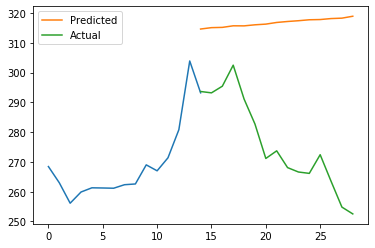

Epoch [17100/20000]. Train loss : 491.231. Test loss : 2089.902
Epoch [17200/20000]. Train loss : 530.426. Test loss : 2834.579
Epoch [17300/20000]. Train loss : 516.935. Test loss : 2621.071
Epoch [17400/20000]. Train loss : 485.431. Test loss : 1174.565
Epoch [17500/20000]. Train loss : 483.874. Test loss : 1794.876
Epoch [17600/20000]. Train loss : 494.960. Test loss : 2517.321
Epoch [17700/20000]. Train loss : 497.239. Test loss : 1360.587
Epoch [17800/20000]. Train loss : 487.815. Test loss : 3318.752
Epoch [17900/20000]. Train loss : 516.482. Test loss : 2529.684
Epoch [18000/20000]. Train loss : 507.537. Test loss : 1753.899


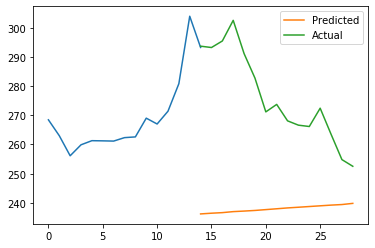

Epoch [18100/20000]. Train loss : 471.910. Test loss : 3727.270
Epoch [18200/20000]. Train loss : 505.065. Test loss : 3183.338
Epoch [18300/20000]. Train loss : 466.189. Test loss : 2856.289
Epoch [18400/20000]. Train loss : 476.148. Test loss : 3040.693
Epoch [18500/20000]. Train loss : 431.990. Test loss : 3542.869


KeyboardInterrupt: 

In [415]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=20000)

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(X_test[-1].cpu())
plt.plot(np.arange(y_test[-1].shape[0])+len(X_test[-1])-1,y_test[-1].cpu())


In [ ]:
with torch.no_grad():
    pred = model(X_test[-1].reshape(1,T,1))
    plt.plot(X_test[-1].cpu())
    plt.plot(np.arange(pred.shape[1])+14,pred.reshape(-1).cpu())

In [ ]:
pred